<a href="https://colab.research.google.com/github/Avenge-PRC777/YOLOv1_from_scratch_in_Keras/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT BASIC LIBRARIES

In [214]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize) # To show entire array

In [215]:
# Connecting to Drive
from google.colab import drive
drive.mount("/content/gdrive",force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [216]:
# PRIMARY DATASET: 700*256*256*3=137 million
# NETWORK PARAMS: 130 million (Yolov1), 35 million (Faster yolo v1), 6 million (Faster Limited yolo v1)

#Dataset created with:
#!python generateShapesAndBBoxes.py -n 700 --width 256 --height 256 --max-shapes 3 --min-shapes 0 -o None --allow-overlap
#! cp -R '/content/None' '/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None5000'
#Dataset Path
datasetPath='/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'
#os.listdir(datasetPath)

In [217]:
labels=json.load(open(datasetPath+'/labels.json'))
N=len(labels)
print("No of images, ",N)
#print(labels[0]['boxes'])
#print(labels[0]['boxes'][0]['x1'])
# No of bounding boxes per grid, B
B=1
# No of grids,S*S
S=16
# No. of classes, C
C=3 #3 for Shapes 1 for Aeroplane
# Output=SxSx(5B+C)
I_S=256 # Image dimension I_SxI_S
classes={'circle':0,'triangle':1,'rectangle':2}
lenClasses=len(classes)
#print(lenClasses)
norm_const=I_S/S

No of images,  2500


#PREPROCESS DATA

## VISUALIZE BOUNDING BOXES

In [ ]:
labels=json.load(open(datasetPath+'/labels.json'))
x1='x1'
x2='x2'
y1='y1'
y2='y2'
boxes='boxes'
classVar='class'
def visualizeBoxes(start,end):
  for i in range(start,end+1):
    image=cv2.imread(datasetPath+'/'+str(i)+'.png')
    for j in range(0,len(labels[i][boxes])):
      cx1=labels[i][boxes][j][x1]
      cx2=labels[i][boxes][j][x2]
      cy1=labels[i][boxes][j][y1]
      cy2=labels[i][boxes][j][y2]
      cls=labels[i][boxes][j][classVar]
      print(cx1,cy1,cx2,cy2,cls)
      image=cv2.rectangle(image,(cx1,cy1),(cx2,cy2),(3,43,123),1) # UPPER LEFT COORD, BOTTOM RIGHT COORD
      cv2.putText(image,cls,(cx1,cy1-10),cv2.FONT_HERSHEY_COMPLEX,0.5, (3,43,123), 2)
    plt.figure()
    plt.imshow(image)

111 105 227 117 rectangle
189 123 206 199 rectangle


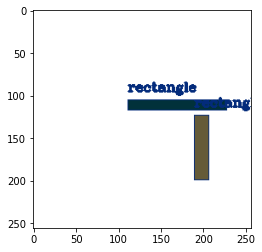

In [ ]:
visualizeBoxes(0,0)

## PREPARING NUMPY IMAGE, GROUND TRUTH (USED ONCE)

The centerx, centery are normalized to 0-1 from grid location. The h, w are normalized to 0-1 with respect to image size.

Let const, k=Image_size/(Grid_size,S)

position in grid=int ( cx / k )

normalized cx, ncx= ( cx' - grid * k ) / k

cx'=ncx x k+grid x k=int ( ( ncx + grid ) * k )

In [ ]:
# USED ONCE, IGNORE
labels=json.load(open(datasetPath+'/labels.json'))
img=np.zeros((N,I_S,I_S,3)) # 700x256x256x3
gt=np.zeros((N,S,S,5+lenClasses)) # 700x16x16x(5+3=8), output=700x16x16x(5B+3=13)
start=0
end=N
for i in range(start,end):
  temp_image=cv2.imread(datasetPath+'/'+str(i)+'.png') # Load 'i' th image
  temp_image=temp_image/255 # NORMALIZE IMAGE ELSE LOSS WILL BE HUGE
  img[i]=temp_image # Save it in 'i'th slot of numpy array
  #iterate over 'boxes'JSON array
  for box in labels[i][boxes]:
    cx1,cx2=box[x1],box[x2]
    cy1,cy2=box[y1],box[y2]
    # Design one hot vector, [0]*3 gives [0,0,0]
    onehot=[0]*lenClasses
    onehot[classes[box[classVar]]]=1 # box[classVar] gives string 'className', which is fed into classes dictionary, which gives position (0/1/2)
    # Centers and h,w
    cx,cy,h,w=(cx1+cx2)/2.0,(cy1+cy2)/2.0,np.abs(cy2-cy1),np.abs(cx2-cx1)
    # Now, to compute where in a grid of SxS, the center would lie
    posx,posy=int((cx*S)/I_S),int((cy*S)/I_S)
    
    # NORMALIZE h,w
    h=h/I_S
    w=w/I_S
    # NORMALIZE cx,cy
    cx=(cx-posx*norm_const)/norm_const
    cy=(cy-posy*norm_const)/norm_const
    # RESTORING cx,cy from normalized values
    #cxo=(cx+posx)*norm_const
    #cyo=(cy+posy)*norm_const

    gt[i,posx,posy]=1,cx,cy,h,w,*onehot # The asterisk opens the array (considered as one unit) into 3 separate values, so that 8 are stored as set.

In [ ]:
# USED ONCE, IGNORE
np.save('Image_Data',img)
np.save('Ground_Truth_In_YOLO_Format',gt)
# SAVE TO GOOGLE DRIVE
!cp '/content/Image_Data.npy' 'gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'
!cp '/content/Ground_Truth_In_YOLO_Format.npy' 'gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'
!ls 'gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'

0.png	  1451.png  1902.png  2353.png	554.png
1000.png  1452.png  1903.png  2354.png	555.png
1001.png  1453.png  1904.png  2355.png	556.png
1002.png  1454.png  1905.png  2356.png	557.png
1003.png  1455.png  1906.png  2357.png	558.png
1004.png  1456.png  1907.png  2358.png	559.png
1005.png  1457.png  1908.png  2359.png	55.png
1006.png  1458.png  1909.png  235.png	560.png
1007.png  1459.png  190.png   2360.png	561.png
1008.png  145.png   1910.png  2361.png	562.png
1009.png  1460.png  1911.png  2362.png	563.png
100.png   1461.png  1912.png  2363.png	564.png
1010.png  1462.png  1913.png  2364.png	565.png
1011.png  1463.png  1914.png  2365.png	566.png
1012.png  1464.png  1915.png  2366.png	567.png
1013.png  1465.png  1916.png  2367.png	568.png
1014.png  1466.png  1917.png  2368.png	569.png
1015.png  1467.png  1918.png  2369.png	56.png
1016.png  1468.png  1919.png  236.png	570.png
1017.png  1469.png  191.png   2370.png	571.png
1018.png  146.png   1920.png  2371.png	572.png
1019.png  1470.png 

## LOADING NUMPY IMAGE, GROUND TRUTH

In [5]:
# LOAD DATA
# Image values are within 0-255 and gt values accordingly.
#Dataset Path
datasetPath='/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'
img=np.load(datasetPath+'/'+'Image_Data.npy')
gt=np.load(datasetPath+'/'+'Ground_Truth_In_YOLO_Format.npy')
#plt.imshow(img[0].astype(int))

# TRAIN TEST VAL

In [85]:
# DIVIDE TRAIN, TEST, VAL
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(img,gt,test_size=0.1,random_state=42)
del img,gt
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=42)
print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)

NameError: ignored

#IMPORT KERAS

In [7]:
%tensorflow_version 1.x
#https://hackernoon.com/understanding-yolo-f5a74bbc7967
from keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dense,BatchNormalization,Input,Dropout,ZeroPadding2D,Flatten, Reshape
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
from keras.callbacks import ReduceLROnPlateau

TensorFlow 1.x selected.


Using TensorFlow backend.


#YOLO LOSS

y_true and y_pred are Theano/Tensorflow tensors. Tensors are similar to numpy multidimensional array but both are not same.

That means everything related to y_ture and y_pred is associated with tf.something **and not np.something**.

However, since keras is a high level interface with tf as backend and is in a sense separate from tf, we use keras.backend as K, so associated with K.something

**numpy array is like c array**

**tensor is not like c array**
tensor=[ [A] , [B] , [C] ]

A=[[X],[Y]] i.e, there are levels of looping

Refer- https://www.quora.com/How-does-tf-slice-work-in-TensorFlow

## HOW TENSOR WORKS

**Meaning of axis in tensor**:

Suppose tensor shape is [12,7,8]

*Axis 0 means 7 x 8 (12 is axis0, it becomes channel)*

*Axis 1 means 12 x 8 (7 is axis1, it becomes channel)*

*Axis 2 means 12 x 7 (8 is axis1, it becomes channel)*

>[2,2] is not equal to [2,2,1]. You can't add [2,2] to [2,2,4] but you can for [2,2,1]. So, you have to conisder **tf.reshape(tensor,[2,2,1])**


### Addition
There is no function to add 2 tensors with **axis** argument, so:

Addition of a [4,2,3] tensor with [6,2,3] **will give error**

Addition of a [1,2,3] (A) with [n,2,3] (B) will be [n,2,3] (C) with automatic addition of A's 2,3 to B's each 2,3 **point/element wise**

Only [1,2,3] or [n,2,3] tensor can be added with [n,2,3] tensor

### Division
Same goes for division, [n,2,3] can be divided only by [n,2,3] or [1,2,3] (**point/element wise ovio**) resulting in a [n,2,3] tensor

### Multiplication
Same goes for division, [n,2,3] can be multiplied only by [n,2,3] or [1,2,3] (**point/element wise ovio**) resulting in a [n,2,3] tensor

# Ultimate meaning
[a,b,c,d,x,y] (*/+) [a,b,c,d,1,y] or [a,b,c,d,x,y] is allowed. Element wise operation will happen

In [ ]:
# HOW TENSORS WORK
import tensorflow as tf
from keras import backend as K

data = np.reshape(np.arange(96), [2,4,4,3])
x = tf.constant(data)
print(x)
result = tf.gather_nd(x, [0,1])

data2=np.reshape(np.arange(4),[2,2])
xs=tf.constant(data2)
ys=xs[:,0]
#A graph contains tensors and operations. To initiate a graph, a session is created which runs the graph.
#In other words, graph provides a schema whereas a session processes a graph to compute values( tensors ).
# When you compile model, you are compiling the graph. 
# A session contains all tensors (graph object), variables, operations(ops).The 'with' closes the session.

#Within a Session we can index tensor like a normal numpy
with tf.Session() as sess:
  print("y outside, ", sess.run(ys))
  sess.run(tf.initialize_all_variables())
  print(sess.run(tf.shape(x)))
  y=x[:,:,:,0:2] # EXACT MANIPULATION LIKE NUMPY
  print(sess.run(tf.shape(y)))
  t=sess.run(K.mean(y[:,:,:,0]-x[:,:,:,1]))
print(t)

# Checking if K.sum() sums required parts
data=np.zeros((2,2,3,2))
datax=np.zeros((2,2,3,2))
data1=np.zeros((2,3,2))
data2=np.zeros((2,3,2))
data1[0,0,0],data1[0,1,0],data1[0,2,0],data1[1,0,0],data1[1,1,0],data1[1,2,0]=1,2,4,4,5,6
data1[0,0,1],data1[0,1,1],data1[0,2,1],data1[1,0,1],data1[1,1,1],data1[1,2,1]=10,11,10,14,15,1
data2[0,0,0],data2[0,1,0],data2[0,2,0],data2[1,0,0],data2[1,1,0],data2[1,2,0]=0,9,-4,3,2,-6
data2[0,0,1],data2[0,1,1],data2[0,2,1],data2[1,0,1],data2[1,1,1],data2[1,2,1]=1,1,1,4,5,5

data[0],data[1]=data1,data2
data1[0,0,0],data1[0,1,0],data1[0,2,0],data1[1,0,0],data1[1,1,0],data1[1,2,0]=4,4,4,4,4,4
data1[0,0,1],data1[0,1,1],data1[0,2,1],data1[1,0,1],data1[1,1,1],data1[1,2,1]=1,1,1,1,1,1
data2[0,0,0],data2[0,1,0],data2[0,2,0],data2[1,0,0],data2[1,1,0],data2[1,2,0]=0,0,0,0,0,0
data2[0,0,1],data2[0,1,1],data2[0,2,1],data2[1,0,1],data2[1,1,1],data2[1,2,1]=5,5,5,5,5,5
datax[0],datax[1]=data1,data2
# I want mean(4-10),(6-1) [mean of last column difference]
x=tf.constant(data)
y=tf.constant(datax)
with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())
  t=sess.run(K.sum(x[:,:,:]))
  print(sess.run(x[:,:,:,0]*(x[:,:,:,1]-y[:,:,:,1])))
  print(sess.run(K.sum(x[:,:,:,1]-y[:,:,:,1])))

# Checking if 2*2 matrix is multiplied individually with a 2*2*2 matrix
data1=np.zeros((2,2))
data1[0,0],data1[0,1],data1[1,0],data1[1,1]=1,2,3,4
data2=np.zeros((2,2,2))
data2[0,0,0],data2[0,1,0],data2[1,0,0],data2[1,1,0]=2,2,2,2
data2[0,0,1],data2[0,1,1],data2[1,0,1],data2[1,1,1]=3,3,3,3
x=tf.constant(data1)
y=tf.constant(data2)
with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())
  print("x, ",sess.run(x))
  z=tf.reshape(x,shape=[2,2,1]) # Reshaping to make the dimensions same makes it work correctly
  print("y sub, ",sess.run(y[:,:,0]))
  t=y*z # Normal multiplication
  print("Add, ",sess.run(x+y))
  print("Verify multi, ",sess.run(t[:,:,1]))

Tensor("Const_163:0", shape=(2, 4, 4, 3), dtype=int64)
y outside,  [0 2]
[2 4 4 3]
[2 4 4 2]
-1
[[[  9.  20.  36.]
  [ 52.  70.   0.]]

 [[ -0. -36.  16.]
  [ -3.   0.  -0.]]]
42.0
x,  [[1. 2.]
 [3. 4.]]
y sub,  [[2. 2.]
 [2. 2.]]
Add,  [[[3. 5.]
  [5. 7.]]

 [[3. 5.]
  [5. 7.]]]
Verify multi,  [[ 3.  6.]
 [ 9. 12.]]


In [ ]:
data1=np.zeros((2,2))
data1[0,0],data1[0,1],data1[1,0],data1[1,1]=1,2,3,4
data2=np.zeros((2,2))
data2[0,0],data2[0,1],data2[1,0],data2[1,1]=2,2,2,2
x=tf.constant(data1)
x_reshaped1=tf.reshape(x,[1,2,2]) # 1 x 2 x 2, axis=0 added
x_reshaped2=2*tf.repeat(x_reshaped1,repeats=[4],axis=0)
x_reshaped3=tf.repeat(x_reshaped1,repeats=[6],axis=0)
batch_emul=tf.shape(x_reshaped2)[0]
y=tf.constant(data2)
data4=np.reshape(np.arange(S),[1,S])
data4=tf.constant(data4)
data4=tf.repeat(data4,repeats=[S],axis=0)
with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())
  print(sess.run(x*y))
  print(sess.run(tf.shape(x_reshaped3)))
  print(sess.run(batch_emul))
  print(sess.run(x_reshaped2[3,:,:]))
  print(sess.run((x_reshaped2*x_reshaped2)))
  print(sess.run(tf.shape(data4)))
  print(sess.run(data4))
  print(sess.run(tf.transpose(data4)))
#print(x.get_shape().as_list())

[[2. 4.]
 [6. 8.]]
[6 2 2]
4
[[2. 4.]
 [6. 8.]]
[[[ 4. 16.]
  [36. 64.]]

 [[ 4. 16.]
  [36. 64.]]

 [[ 4. 16.]
  [36. 64.]]

 [[ 4. 16.]
  [36. 64.]]]
[16 16]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]
[[ 0  0  0  0  0  0  0 

## LOSS FUNCTION
DONT USE THIS AS IT DOES COMPUTATIONS WITHIN session. and if compile() hits session() it will demand input

In [ ]:
# IOU Calculation between two bounding boxes
def return_mean_iou(box_true,box_pred):
  restored_gt_cx=(i+box_true[:,:,:,0])*norm_const
  restored_gt_cy=(j+box_true[:,:,:,1])*norm_const
  restored_gt_h=box_true[:,:,:,2]*I_S
  restored_gt_w=box_true[:,:,:,3]*I_S
  restored_pred_cx=(i+box_pred[:,:,:,0])*norm_const
  restored_pred_cy=(j+box_pred[:,:,:,0])*norm_const
  restored_pred_h=box_pred[:,:,:,0]*norm_const
  restored_pred_w=box_pred[:,:,:,0]*norm_const
  x1=restored_gt_cx-restored_gt_w/2
  y1=restored_gt_cy-restored_gt_h/2
  x2=restored_gt_cx+restored_gt_w/2
  y2=restored_gt_cy+restored_gt_h/2
  x3=restored_pred_cx-restored_gt_w/2
  y3=restored_pred_cy-restored_gt_h/2
  x4=restored_pred_cx+restored_gt_w/2
  y4=restored_pred_cy+restored_gt_h/2
  x5=np.max(x1,x3)
  y5=np.max(y1,y3)
  x6=np.min(x2,x4)
  y6=np.min(y2,y4)
  interScn=(x6-x5)*(y6-y5)
  if x5>=x6 and y5>=y6:
    interScn=0
  union=(restored_gt_h*restored_gt_w)+(restored_pred_h*restored_pred_w)
  return interScn/union

In [ ]:
from keras import backend as K
coord=5
noobj=0.5 # We want loss from coordinates to have more weightage

# A simple loss
# How output is arranged-> B confidence values, 4B offsets/coordinates, one hot vector
# y_pred=[batch,S,S,5B+C],y_true=[batch,S,S,5+C]
def yolo_loss_trial(y_true,y_pred):
  localizationLoss=0.0
  classificationLoss=0.0
  confidenceLoss=0.0

  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    # CLASSIFICATION LOSS (which object)
    # K.sum with no axis argument sums all and gives one scalar value
    #y_true[:,:,:,0] is 0 for no boxes and 1 for boxes, it is 16*16 while the difference is 16*16*3
    # So, each difference matrix is multiplied with y_true[:,:,:,0] resulting in one 16*16*3 matrix, whose
    #scalar sum K.sum() gives
    #y_true_reshaped=tf.reshape(y_true[:,:,:,0],shape=[S,S,1]) #16x16x1
    classificationLoss=sess.run(K.sum(y_true[:,:,:,0]*K.square(y_true[:,:,:,5:8]-y_pred[:,:,:,5*B:5*B+C])))

    # LOCALIZATION LOSS(how good bouning box coordinates are)
    # Iterate over each 4 set of 4B coordinates and compute loss
    for i in range(B,5*B,4):
      localizationLoss=localizationLoss+sess.run(K.sum(y_true[:,:,:,0]*K.square(y_true[:,:,:,1:3]-y_pred[:,:,:,i:i+2])))
      localizationLoss=localizationLoss+sess.run(K.sum(y_true[:,:,:,0]*K.square(K.sqrt(y_true[:,:,:,3:5])-K.sqrt(y_pred[:,:,:,i+2:i+4]))))
    localizationLoss=localizationLoss*coord

    # CONFIDENCE LOSS (probability that object is there)
  return localizationLoss+classificationLoss+confidenceLoss

## LOSS FUNCTION WITHOUT SESSION

Session is only used to print and visualize shapes and data

Using session in loss function will lead to error while compiling model because in session model will expect batch inputs but while at compiling stage, you dont have input.

The idea to implement IoU for 2 tensors without batch headache and bool comparision for checking if intersecting or not headache: https://stackoverflow.com/questions/62444772/to-find-the-intersection-of-two-bounding-box-in-tensorflow
```
import tensorflow as tf

def box_intersections(set1, set2):
    set1 = tf.expand_dims(set1, axis=-1)
    x_min = tf.math.maximum(set1[:, 0], set2[:, 0])
    y_min = tf.math.maximum(set1[:, 1], set2[:, 1])
    x_max = tf.math.minimum(set1[:, 2], set2[:, 2])
    y_max = tf.math.minimum(set1[:, 3], set2[:, 3])
    dx = tf.math.maximum(x_max - x_min, 0)
    dy = tf.math.maximum(y_max - y_min, 0)
    return dx * dy

# Example
tf.random.set_seed(0)
# Make random boxes
n1 = 10
n2 = 20
set1 = tf.random.uniform((n1, 2))
set1 = tf.concat([set1, set1 + tf.random.uniform((n1, 2))], axis=1)
set2 = tf.random.uniform((n2, 2))
set2 = tf.concat([set2, set2 + tf.random.uniform((n2, 2))], axis=1)
# Compute intersections
intersect = box_intersections(set1, set2)
print(intersect.shape)
```

In [218]:
'''
# Things rectified
1)  cx_restored_gt_tensor=norm_const*(indices_tensor_X+box_true[:,:,:,2]) Note the
'2', for ground truth coordinates are in 1,2,3,4 indices not 2,3,4,5 so it was changed
2) smooth was not added to intersection as if intersection and union are 0, addition to both will
give IoU as 1 which is not desirable
3)tf.math.maximums were removed which were unnecessary because ultimately we are zeroing
unnecesary grid points by multiplying with y_true[:,:,:,0]
4) The biggest mistake was IoU formula is intersection/(total area -intersection), union IS NOT the
sum of 2 areas but sum-intersection.
'''

import tensorflow as tf
from keras import backend as K

# Creating INDICES tensor to add to normalized centers
indices=np.reshape(np.arange(S),[1,S]) # consists of 0 to S-1, i.e., indices.
indices_tensor_Y=tf.constant(indices,dtype=float) # 1x S
indices_tensor_Y=tf.repeat(indices_tensor_Y,repeats=[S],axis=0) # S x S, 0123S;0123S;0123S S rows
indices_tensor_X=tf.transpose(indices_tensor_Y) # S x S
indices_tensor_Y=tf.reshape(indices_tensor_Y,[1,S,S]) # 1 x S x S
indices_tensor_X=tf.reshape(indices_tensor_X,[1,S,S]) # 1 x S x S
#indices_tensor=tf.repeat(indices_tensor,repeats=[batch_tensor],axis=0) # batch x S x S
# repeat() will repeat axis-0 (SxS), batch_tensor number of times along the channel

# IOU Calculation between two bounding boxes
def return_iou_tensor(box_true,box_pred,i):
  '''
  box_true=batch x S x S x 8
  box_pred=batch x S x S x (5B+C)
  '''

  # Restored gt
  cx_restored_gt_tensor=norm_const*(indices_tensor_X+box_true[:,:,:,1]) # 1 x S x S + batch x S x S = batch x S x S
  cy_restored_gt_tensor=norm_const*(indices_tensor_Y+box_true[:,:,:,2]) # 1 x S x S + batch x S x S = batch x S x S
  h_restored_gt_tensor=box_true[:,:,:,3]*I_S # batch x S x S
  w_restored_gt_tensor=box_true[:,:,:,4]*I_S # batch x S x S

  # Restored predicted
  cx_restored_pred_tensor=norm_const*(indices_tensor_X+box_pred[:,:,:,B+4*i]) # 1 x S x S + batch x S x S = batch x S x S
  cx_restored_pred_tensor=tf.math.maximum(cx_restored_pred_tensor,0)# To remove negative values
  cy_restored_pred_tensor=norm_const*(indices_tensor_Y+box_pred[:,:,:,B+1+4*i]) # 1 x S x S + batch x S x S = batch x S x S
  cy_restored_pred_tensor=tf.math.maximum(cy_restored_pred_tensor,0)# To remove negative values
  h_restored_pred_tensor=box_pred[:,:,:,B+2+4*i]*I_S # batch x S x S
  h_restored_pred_tensor=tf.math.maximum(h_restored_pred_tensor,0)# To remove negative values
  w_restored_pred_tensor=box_pred[:,:,:,B+3+4*i]*I_S # batch x S x S
  w_restored_pred_tensor=tf.math.maximum(w_restored_pred_tensor,0)# To remove negative values

  # min max of intersection box all, batch x S x S
  x_min_tensor=tf.math.maximum(cx_restored_gt_tensor-w_restored_gt_tensor/2,cx_restored_pred_tensor-w_restored_pred_tensor/2)
  y_min_tensor=tf.math.maximum(cy_restored_gt_tensor-h_restored_gt_tensor/2,cy_restored_pred_tensor-h_restored_pred_tensor/2)
  x_max_tensor=tf.math.minimum(cx_restored_gt_tensor+w_restored_gt_tensor/2,cx_restored_pred_tensor+w_restored_pred_tensor/2)
  y_max_tensor=tf.math.minimum(cy_restored_gt_tensor+h_restored_gt_tensor/2,cy_restored_pred_tensor+h_restored_pred_tensor/2)
  w_intersection=tf.math.maximum(x_max_tensor-x_min_tensor,0)
  h_intersection=tf.math.maximum(y_max_tensor-y_min_tensor,0)
  intersection_tensor=w_intersection*h_intersection # batch x S x S
  total_area_tensor=(w_restored_gt_tensor*h_restored_gt_tensor)+(w_restored_pred_tensor*h_restored_pred_tensor) # batch x S x S
  union_tensor=total_area_tensor-intersection_tensor
  smooth=0.001 # We are using smooth because we dont want division by 0
  return (intersection_tensor)/(union_tensor+smooth) #batch x S x S

In [223]:
'''
# Things rectified
1)  y_true[:,:,:,0]*iou_tensor will put 0s in not required places and IoU in required
places but K.mean() will give that IoU/(SxS), for example if one 0.9 and rest 0s, then mean
IoU=0.9/256 which is very small, to prevent this non zeros count is found
and mean will be non zeros values' sum/their count
'''
def mean_iou_metric(y_true,y_pred):
  mean_iou=0.0
  for i in range(0,B):
    iou_tensor=return_iou_tensor(y_true,y_pred,i)
    non_zeros=tf.math.count_nonzero(y_true[:,:,:,0]*iou_tensor)
    non_zeros=tf.cast(non_zeros,dtype=tf.float32) # Casting, else error is shown
    non_zeros=tf.math.maximum(non_zeros,0.001) # to prevent division by 0 
    mean_iou=mean_iou+(K.sum(y_true[:,:,:,0]*iou_tensor)/non_zeros)
  return mean_iou/B

In [224]:
from keras import backend as K
coord=10
noobj=0.1 # We want loss from coordinates to have more weightage
# A simple loss
# How output is arranged-> B confidence values, 4B offsets/coordinates, one hot vector
# y_pred=[batch,S,S,5B+C],y_true=[batch,S,S,5+C]
def yolo_loss_trial(y_true,y_pred):
  localizationLoss=0.0
  classificationLoss=0.0
  confidenceLoss=0.0
  batchsize_as_tensor_obj=tf.shape(y_pred)[0]
  #batch=y_true.get_shape().as_list()
  #batch=batch[0] # Compile time error as no batch input given at compile time
  object_presence=tf.reshape(y_true[:,:,:,0],shape=[batchsize_as_tensor_obj,S,S,1]) #from batchx16x16 to batchx16x16x1
  #batch x S x S x 1

  # CLASSIFICATION LOSS
  # batch x S x S x 1 * batch x S x S x 3, allowed
  classificationLoss=K.sum(K.square((object_presence*y_true[:,:,:,5:8])-y_pred[:,:,:,5*B:5*B+C]))

  # LOCALIZATION LOSS
  for i in range(B,5*B,4):
    # batch x S x S x 1 * batch x S x S x 2, allowed
    localizationLoss=localizationLoss+(K.sum(K.square((object_presence*y_true[:,:,:,1:3])-y_pred[:,:,:,i:i+2])))
    localizationLoss=localizationLoss+(K.sum(K.square(K.sqrt(object_presence*y_true[:,:,:,3:5])-K.sqrt(y_pred[:,:,:,i+2:i+4]))))
  localizationLoss=localizationLoss*coord

  # CONFIDENCE LOSS
  for i in range(0,B):
    y_iou=return_iou_tensor(y_true,y_pred,i) #  batch x S x S
    # take 1 from 1,noobj and noobj from noobj,0
    object_presence_modified=tf.math.maximum(y_true[:,:,:,0],noobj) # batch x S x S
    #confidenceLoss=confidenceLoss+(K.sum(object_presence_modified*K.square(y_true[:,:,:,0]-y_pred[:,:,:,i]*y_iou))) # batch x S x S ops
    confidenceLoss=confidenceLoss+(K.sum(K.square((object_presence_modified*y_true[:,:,:,0]*y_iou)-y_pred[:,:,:,i]))) # batch x S x S ops

  #return K.log(localizationLoss+classificationLoss+confidenceLoss)
  return (localizationLoss+classificationLoss+confidenceLoss)

#YOLO V1 MODEL (Image must be multiple of SxS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 262, 262, 3)       0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pool_layer1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 64, 64, 192)       110784    
___________________________________________

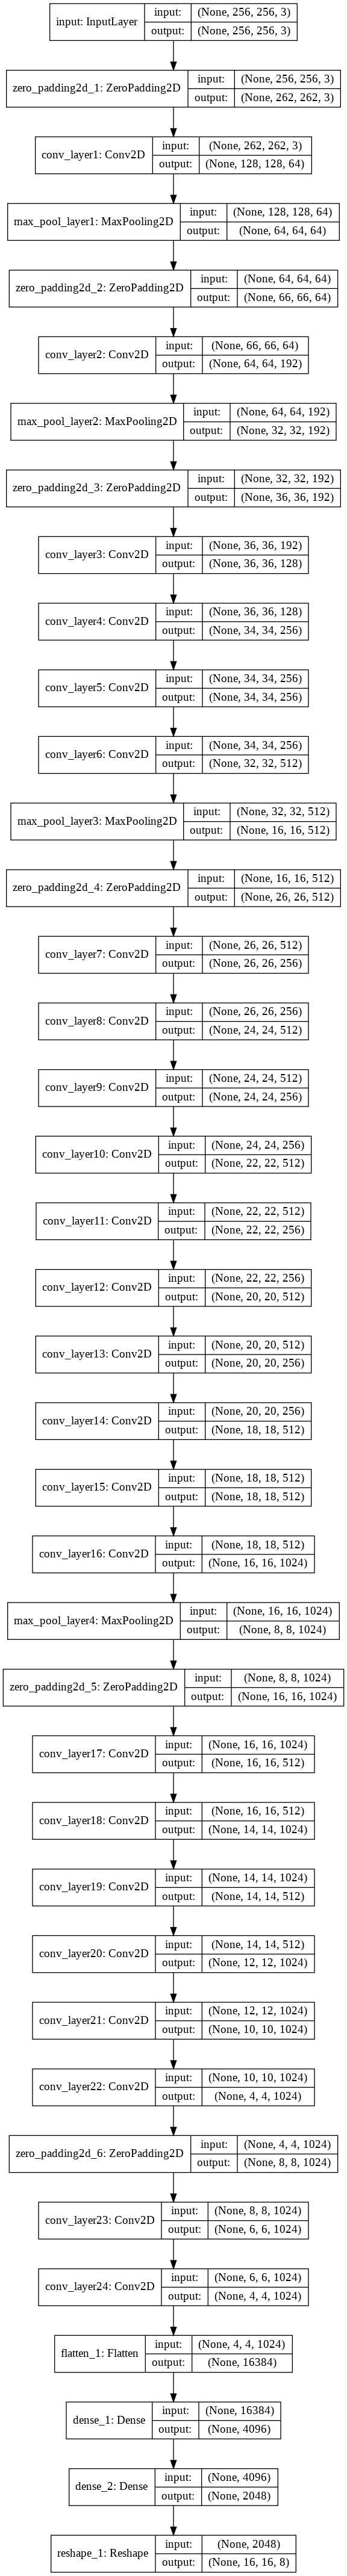

In [12]:
from keras import backend as K
import tensorflow as tf

def custom_activation(x):
  # LEAKY RELU
  isPositive=K.cast(K.greater(x,0),K.floatx()) # U HAVE TO CAST THE OUTPUT OF COMAPARISION TO FLOAT, BOOL NOT ACCEPTED
  # OUTPUT OF THIS FUNCTION IS A TENSOR
  return (isPositive*x)+(1-isPositive)*0.1*x

###############  BLOCK 1 ##############################
input_=Input(shape=(256,256,3),name='input') #ORIGINAL 448x448x3
zeropad1=ZeroPadding2D(padding=(3,3))(input_) # PADDING MAKES 448->3+448+3, it is required to bring output to 112

convLayer1=Conv2D(64,(7,7),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer1')(zeropad1)
maxpoolLayer1=MaxPooling2D(pool_size=(2,2),name='max_pool_layer1')(convLayer1)
zeropad2=ZeroPadding2D(padding=(1,1))(maxpoolLayer1)
########################################################

###############  BLOCK 2 ##############################
convLayer2=Conv2D(192,(3,3),padding='valid',activation=custom_activation,name='conv_layer2')(zeropad2)
maxpoolLayer2=MaxPooling2D(pool_size=(2,2),name='max_pool_layer2')(convLayer2)
zeropad3=ZeroPadding2D(padding=(2,2))(maxpoolLayer2)
########################################################

###############  BLOCK 3 ##############################
convLayer3=Conv2D(128,(1,1),padding='valid',activation=custom_activation,name='conv_layer3')(zeropad3)
convLayer4=Conv2D(256,(3,3),padding='valid',activation=custom_activation,name='conv_layer4')(convLayer3)
convLayer5=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer5')(convLayer4)
convLayer6=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer6')(convLayer5)
maxpoolLayer3=MaxPooling2D(pool_size=(2,2),name='max_pool_layer3')(convLayer6)
zeropad4=ZeroPadding2D(padding=(5,5))(maxpoolLayer3)
########################################################

###############  BLOCK 4 ##############################
convLayer7=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer7')(zeropad4)
convLayer8=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer8')(convLayer7)
convLayer9=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer9')(convLayer8)
convLayer10=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer10')(convLayer9)
convLayer11=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer11')(convLayer10)
convLayer12=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer12')(convLayer11)
convLayer13=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer13')(convLayer12)
convLayer14=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer14')(convLayer13)
convLayer15=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer15')(convLayer14)
convLayer16=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer16')(convLayer15)
maxpoolLayer4=MaxPooling2D(pool_size=(2,2),name='max_pool_layer4')(convLayer16)
zeropad5=ZeroPadding2D(padding=(4,4))(maxpoolLayer4)
###########################################################

###############  BLOCK 5 ##################################
convLayer17=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer17')(zeropad5)
convLayer18=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer18')(convLayer17)
convLayer19=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer19')(convLayer18)
convLayer20=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer20')(convLayer19)
convLayer21=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer21')(convLayer20)
convLayer22=Conv2D(1024,(3,3),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer22')(convLayer21)
zeropad6=ZeroPadding2D(padding=(2,2))(convLayer22)
#############################################################

################ BLOCK 6 ####################################
convLayer23=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer23')(zeropad6)
convLayer24=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer24')(convLayer23)
flattenedLayer1=Flatten()(convLayer24) # Flatten just converts 3d matrix to 1d so that it can be connected to a next Dense Layer
###############################################################

################ BLOCK 7 #########################################
denseLayer1=Dense(units=4096,activation=custom_activation)(flattenedLayer1)
##################################################################

################ BLOCK 8 #########################################
denseLayer2=Dense(units=S*S*(5*B+C),activation='linear')(denseLayer1)
output_=Reshape((S,S,(5*B+C)))(denseLayer2) # Reshapes the 1D to 3D
##################################################################

yolo_model=Model(inputs=input_,outputs=output_)
yolo_model.summary()
from keras.utils import plot_model
plot_model(yolo_model,to_file='unet.png',show_shapes=True)

#FASTER YOLO V1 MODEL (9 CONV LAYERS)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 125, 125, 64)      9472      
_________________________________________________________________
max_pool_layer1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 60, 60, 192)       110784    
_________________________________________________________________
max_pool_layer2 (MaxPooling2 (None, 30, 30, 192)       0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 30, 30, 128)       24704     
_________________________________________________________________
conv_layer4 (Conv2D)         (None, 28, 28, 256)       295

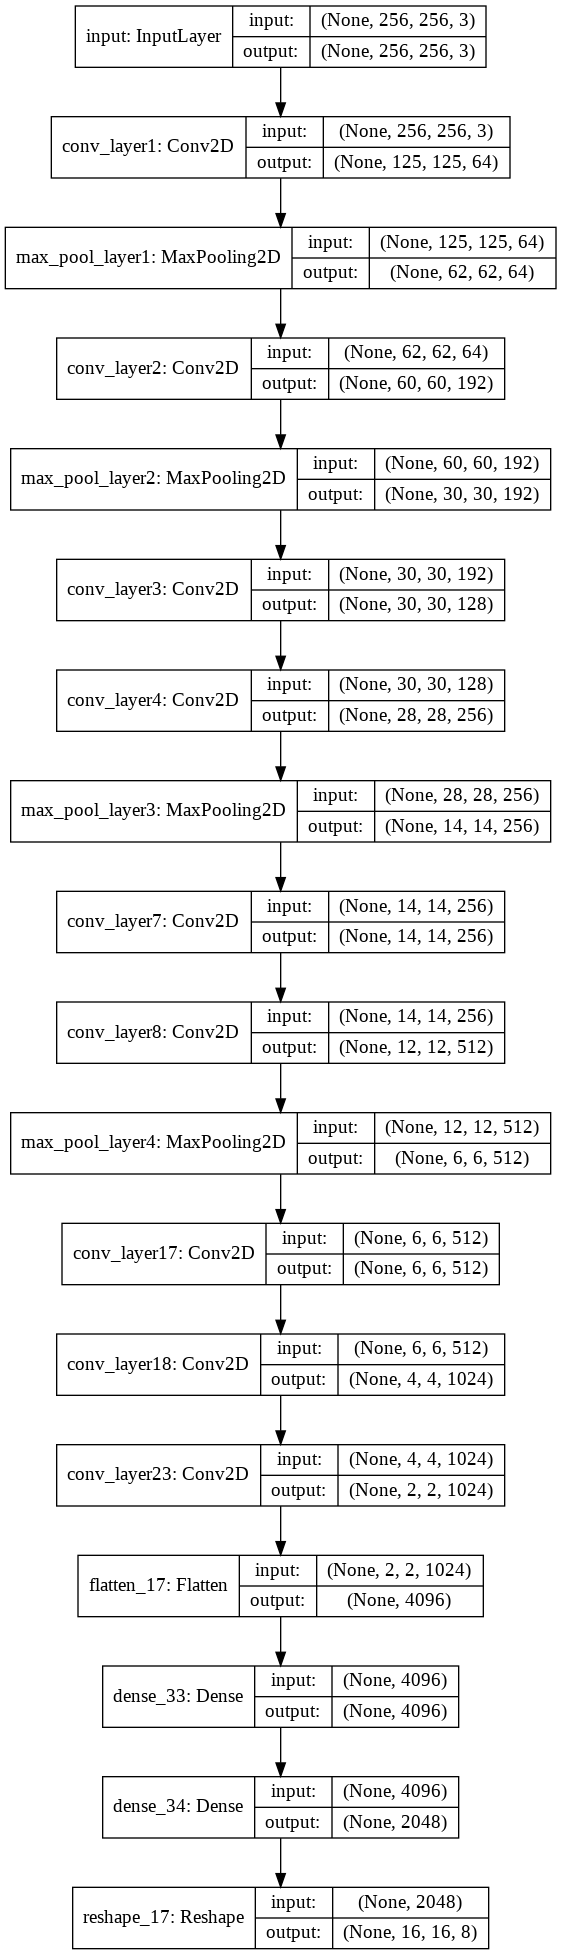

In [221]:
from keras import backend as K
import tensorflow as tf
import math

def custom_activation(x):
  # LEAKY RELU
  #isPositive=K.cast(K.greater(x,0),K.floatx()) # U HAVE TO CAST THE OUTPUT OF COMAPARISION TO FLOAT, BOOL NOT ACCEPTED
  # OUTPUT OF THIS FUNCTION IS A TENSOR
  #return (isPositive*x)+(1-isPositive)*0.1*x

  # GELU
  constant=math.sqrt(2*math.pi)
  return 0.5*x*(1+K.tanh(constant*(x+0.044715*K.pow(x,3))))

###############  BLOCK 1 ##############################
input_=Input(shape=(256,256,3),name='input')
#zeropad1=ZeroPadding2D(padding=(3,3))(input_) # PADDING MAKES 448->3+448+3, it is required to bring output to 112

convLayer1=Conv2D(64,(7,7),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer1')(input_)
maxpoolLayer1=MaxPooling2D(pool_size=(2,2),name='max_pool_layer1')(convLayer1)
#zeropad2=ZeroPadding2D(padding=(1,1))(maxpoolLayer1)
########################################################

###############  BLOCK 2 ##############################
convLayer2=Conv2D(192,(3,3),padding='valid',activation=custom_activation,name='conv_layer2')(maxpoolLayer1)
maxpoolLayer2=MaxPooling2D(pool_size=(2,2),name='max_pool_layer2')(convLayer2)
#zeropad3=ZeroPadding2D(padding=(2,2))(maxpoolLayer2)
########################################################

###############  BLOCK 3 ##############################
convLayer3=Conv2D(128,(1,1),padding='valid',activation=custom_activation,name='conv_layer3')(maxpoolLayer2)
convLayer4=Conv2D(256,(3,3),padding='valid',activation=custom_activation,name='conv_layer4')(convLayer3)
#convLayer5=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer5')(convLayer4)
#convLayer6=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer6')(convLayer5)
maxpoolLayer3=MaxPooling2D(pool_size=(2,2),name='max_pool_layer3')(convLayer4)
#zeropad4=ZeroPadding2D(padding=(5,5))(maxpoolLayer3)
########################################################

###############  BLOCK 4 ##############################
convLayer7=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer7')(maxpoolLayer3)
convLayer8=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer8')(convLayer7)
#convLayer9=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer9')(convLayer8)
#convLayer10=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer10')(convLayer9)
#convLayer11=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer11')(convLayer10)
#convLayer12=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer12')(convLayer11)
#convLayer13=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer13')(convLayer12)
#convLayer14=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer14')(convLayer13)
#convLayer15=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer15')(convLayer14)
#convLayer16=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer16')(convLayer15)
maxpoolLayer4=MaxPooling2D(pool_size=(2,2),name='max_pool_layer4')(convLayer8)
#zeropad5=ZeroPadding2D(padding=(4,4))(maxpoolLayer4)
###########################################################

###############  BLOCK 5 ##################################
convLayer17=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer17')(maxpoolLayer4)
convLayer18=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer18')(convLayer17)
#convLayer19=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer19')(convLayer18)
#convLayer20=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer20')(convLayer19)
#convLayer21=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer21')(convLayer20)
#convLayer22=Conv2D(1024,(3,3),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer22')(convLayer21)
#zeropad6=ZeroPadding2D(padding=(2,2))(convLayer18)
#############################################################

################ BLOCK 6 ####################################
convLayer23=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer23')(convLayer18)
#convLayer24=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer24')(convLayer23)
flattenedLayer1=Flatten()(convLayer23) # Flatten just converts 3d matrix to 1d so that it can be connected to a next Dense Layer
###############################################################

################ BLOCK 7 #########################################
denseLayer1=Dense(units=4096,activation=custom_activation)(flattenedLayer1)
##################################################################

################ BLOCK 8 #########################################
denseLayer2=Dense(units=S*S*(5*B+C),activation='linear')(denseLayer1)
output_=Reshape((S,S,(5*B+C)))(denseLayer2) # Reshapes the 1D to 3D
##################################################################

fast_model=Model(inputs=input_,outputs=output_)
fast_model.summary()
from keras.utils import plot_model
plot_model(fast_model,to_file='unet.png',show_shapes=True)

#FASTER LIMITED YOLO V1 MODEL (TO FIT MY DATASET)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 3)       0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 125, 125, 64)      9472      
_________________________________________________________________
max_pool_layer1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pool_layer3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv_layer7 (Conv2D)         (None, 28, 28, 256)       295

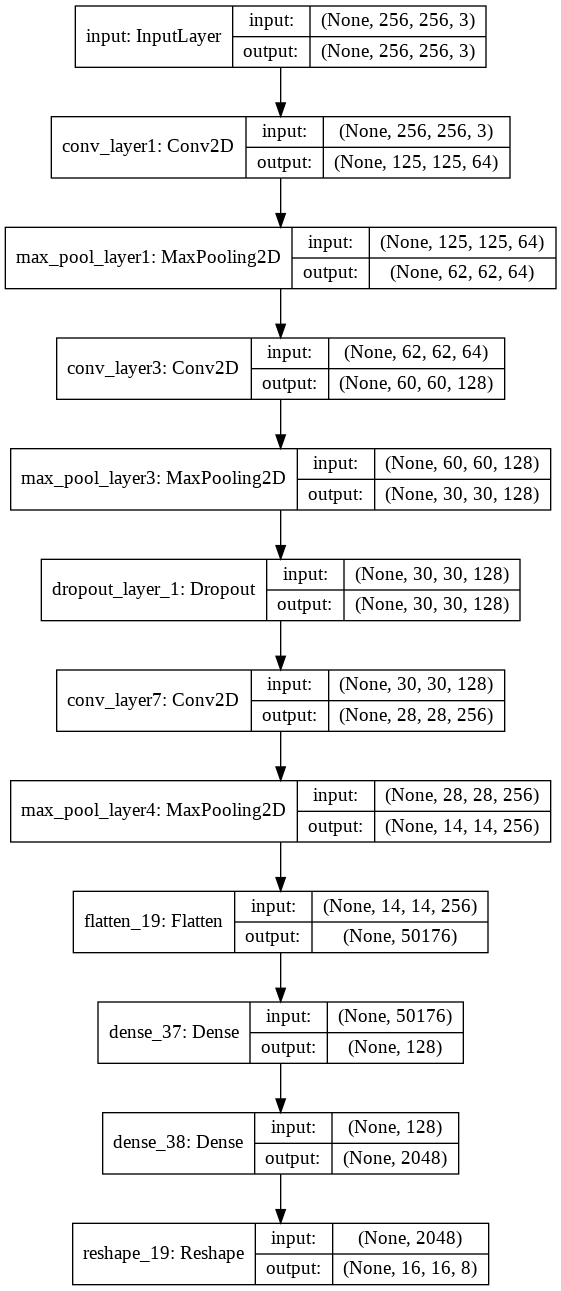

In [267]:
from keras import backend as K
import tensorflow as tf

def custom_activation(x):
  # LEAKY RELU
  isPositive=K.cast(K.greater(x,0),K.floatx()) # U HAVE TO CAST THE OUTPUT OF COMAPARISION TO FLOAT, BOOL NOT ACCEPTED
  # OUTPUT OF THIS FUNCTION IS A TENSOR
  return (isPositive*x)+(1-isPositive)*0.1*x

###############  BLOCK 1 ##############################
input_=Input(shape=(256,256,3),name='input')
#zeropad1=ZeroPadding2D(padding=(3,3))(input_) # PADDING MAKES 448->3+448+3, it is required to bring output to 112

convLayer1=Conv2D(64,(7,7),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer1')(input_)
maxpoolLayer1=MaxPooling2D(pool_size=(2,2),name='max_pool_layer1')(convLayer1)
#zeropad2=ZeroPadding2D(padding=(1,1))(maxpoolLayer1)
########################################################

###############  BLOCK 2 ##############################
#convLayer2=Conv2D(192,(3,3),padding='valid',activation=custom_activation,name='conv_layer2')(maxpoolLayer1)
#maxpoolLayer2=MaxPooling2D(pool_size=(2,2),name='max_pool_layer2')(convLayer2)
#zeropad3=ZeroPadding2D(padding=(2,2))(maxpoolLayer2)
########################################################

###############  BLOCK 3 ##############################
convLayer3=Conv2D(128,(3,3),padding='valid',activation=custom_activation,name='conv_layer3')(maxpoolLayer1)
#convLayer4=Conv2D(256,(3,3),padding='valid',activation=custom_activation,name='conv_layer4')(convLayer3)
#convLayer5=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer5')(convLayer4)
#convLayer6=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer6')(convLayer5)
maxpoolLayer3=MaxPooling2D(pool_size=(2,2),name='max_pool_layer3')(convLayer3)
dropoutLayer1=Dropout(0.5,name='dropout_layer_1')(maxpoolLayer3)
#zeropad4=ZeroPadding2D(padding=(5,5))(maxpoolLayer3)
########################################################

###############  BLOCK 4 ##############################
convLayer7=Conv2D(256,(3,3),padding='valid',activation=custom_activation,name='conv_layer7')(dropoutLayer1)
#convLayer8=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer8')(convLayer7)
#convLayer9=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer9')(convLayer8)
#convLayer10=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer10')(convLayer9)
#convLayer11=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer11')(convLayer10)
#convLayer12=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer12')(convLayer11)
#convLayer13=Conv2D(256,(1,1),padding='valid',activation=custom_activation,name='conv_layer13')(convLayer12)
#convLayer14=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer14')(convLayer13)
#convLayer15=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer15')(convLayer14)
#convLayer16=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer16')(convLayer15)
maxpoolLayer4=MaxPooling2D(pool_size=(2,2),name='max_pool_layer4')(convLayer7)
#zeropad5=ZeroPadding2D(padding=(4,4))(maxpoolLayer4)
###########################################################

###############  BLOCK 5 ##################################
#convLayer17=Conv2D(512,(3,3),padding='valid',activation=custom_activation,name='conv_layer17')(maxpoolLayer4)
#convLayer18=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer18')(convLayer17)
#convLayer19=Conv2D(512,(1,1),padding='valid',activation=custom_activation,name='conv_layer19')(convLayer18)
#convLayer20=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer20')(convLayer19)
#convLayer21=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer21')(convLayer20)
#convLayer22=Conv2D(1024,(3,3),strides=(2,2),padding='valid',activation=custom_activation,name='conv_layer22')(convLayer21)
#zeropad6=ZeroPadding2D(padding=(2,2))(convLayer18)
#############################################################

################ BLOCK 6 ####################################
#convLayer23=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer23')(convLayer17)
#convLayer24=Conv2D(1024,(3,3),padding='valid',activation=custom_activation,name='conv_layer24')(convLayer23)
flattenedLayer1=Flatten()(maxpoolLayer4) # Flatten just converts 3d matrix to 1d so that it can be connected to a next Dense Layer
###############################################################

################ BLOCK 7 #########################################
denseLayer1=Dense(units=128,activation=custom_activation)(flattenedLayer1)
##################################################################

################ BLOCK 8 #########################################
denseLayer2=Dense(units=S*S*(5*B+C),activation='linear')(denseLayer1)
output_=Reshape((S,S,(5*B+C)))(denseLayer2) # Reshapes the 1D to 3D
##################################################################

fast_ltd_model=Model(inputs=input_,outputs=output_)
fast_ltd_model.summary()
from keras.utils import plot_model
plot_model(fast_ltd_model,to_file='unet.png',show_shapes=True)

#COMPILE & TRAIN MODEL

In [268]:
model=fast_ltd_model # SELECT MODEL
model.save_weights('weights.hdf5')
model.compile(optimizer=Adam(learning_rate=1e-5),loss=yolo_loss_trial,metrics=[mean_iou_metric])
#model.compile(optimizer=SGD(learning_rate=1e-5),loss=yolo_loss_trial,metrics=[mean_iou_metric])
model.load_weights('weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=3, min_lr=1e-5,mode='auto') # ADD IN CALLBACK in fit()
# patience is after how many epochs if improvement is not seen, then reduce lr, newlr=lr*factor

In [269]:
for i in range(0,10):
  print("Iteration, ",i)
  history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=16,epochs=32,callbacks=[training_log,checkpointer,reduce_lr],shuffle=True)
  
  # OVERFITTER BELOW, ON 1 IMAGE
  #history=model.fit(X_train[2:3,:,:,:],Y_train[2:3,:,:,:],batch_size=1,epochs=32,callbacks=[training_log,checkpointer,reduce_lr],shuffle=True)
  
  # SAVE MODEL TO DRIVE
  !cp '/content/weights.hdf5' 'gdrive/My Drive/Colab Notebooks/Colab Datasets/Breast_Cancer_HNS/Images'
  # CONFIRM EXECUTION TIMESTAMP
  from datetime import datetime
  import pytz
  tz = pytz.timezone('Asia/Calcutta')
  berlin_now = datetime.now(tz)
  dt_string = berlin_now.strftime("%d/%m/%Y %H:%M:%S")
  print(dt_string)
  #from google.colab import output
  #output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')
# SAVE WHOLE MODEL TO LOCAL/COLAB DRIVE
model.save("FastYolo") #Saves weights also according to official docs
# SAVE MODEL TO GOOGLE DRIVE
!cp '/content/FastYolo' '/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'

Iteration,  0
Train on 1800 samples, validate on 450 samples
Epoch 1/32
1800/1800 [==============================] - 10s 5ms/step - loss: 517.0287 - mean_iou_metric: 0.0020 - val_loss: 358.5193 - val_mean_iou_metric: 1.3057e-04
Epoch 2/32
1800/1800 [==============================] - 7s 4ms/step - loss: 350.5396 - mean_iou_metric: 1.7471e-04 - val_loss: 314.2319 - val_mean_iou_metric: 1.3660e-05
Epoch 3/32
 880/1800 [=============>................] - ETA: 2s - loss: 320.4376 - mean_iou_metric: 1.4585e-05

KeyboardInterrupt: ignored

In [231]:
for i in range(0,10):
  print("Iteration, ",i)
  history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=16,epochs=32,callbacks=[training_log,checkpointer,reduce_lr],shuffle=True)
  
  # OVERFITTER BELOW, ON 1 IMAGE
  #history=model.fit(X_train[2:3,:,:,:],Y_train[2:3,:,:,:],batch_size=1,epochs=32,callbacks=[training_log,checkpointer,reduce_lr],shuffle=True)
  
  # SAVE MODEL TO DRIVE
  !cp '/content/weights.hdf5' 'gdrive/My Drive/Colab Notebooks/Colab Datasets/Breast_Cancer_HNS/Images'
  # CONFIRM EXECUTION TIMESTAMP
  from datetime import datetime
  import pytz
  tz = pytz.timezone('Asia/Calcutta')
  berlin_now = datetime.now(tz)
  dt_string = berlin_now.strftime("%d/%m/%Y %H:%M:%S")
  print(dt_string)
  #from google.colab import output
  #output.eval_js('new Audio("https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3").play()')
# SAVE WHOLE MODEL TO LOCAL/COLAB DRIVE
model.save("FastYolo") #Saves weights also according to official docs
# SAVE MODEL TO GOOGLE DRIVE
!cp '/content/FastYolo' '/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Shape_Detection_YOLO/None2500NoOverlap'

Iteration,  0
Train on 1800 samples, validate on 450 samples
Epoch 1/32
1800/1800 [==============================] - 7s 4ms/step - loss: 184.2022 - mean_iou_metric: 0.4678 - val_loss: 336.5767 - val_mean_iou_metric: 0.0734
Epoch 2/32
1800/1800 [==============================] - 7s 4ms/step - loss: 184.1436 - mean_iou_metric: 0.4484 - val_loss: 337.3318 - val_mean_iou_metric: 0.0756
Epoch 3/32
1800/1800 [==============================] - 7s 4ms/step - loss: 183.9431 - mean_iou_metric: 0.4672 - val_loss: 339.0856 - val_mean_iou_metric: 0.0754
Epoch 4/32
1800/1800 [==============================] - 7s 4ms/step - loss: 183.7968 - mean_iou_metric: 0.4667 - val_loss: 335.0294 - val_mean_iou_metric: 0.0666
Epoch 5/32
1800/1800 [==============================] - 7s 4ms/step - loss: 183.8852 - mean_iou_metric: 0.4701 - val_loss: 337.1194 - val_mean_iou_metric: 0.0705
Epoch 6/32
1800/1800 [==============================] - 7s 4ms/step - loss: 184.0075 - mean_iou_metric: 0.4645 - val_loss: 339.89

In [232]:
# Checking if overfitting for one image is working
#y_predict=model.predict(X_train[2:3,:,:,:])
#y_actual=Y_train[2:3,:,:,:]
print("GT,",y_actual[:,9,0,:])
print("Predicted,",y_predict[:,9,0,:])
#print(y_predict[:,:,:,:])

GT, [[1.         0.21875    0.34375    0.03515625 0.03515625 1.
  0.         0.        ]]
Predicted, [[ 8.60994518e-01  2.18517780e-01  3.43529403e-01  3.59972157e-02
   3.60608436e-02  1.00178337e+00  1.12439855e-04 -3.36904777e-05]]


In [203]:
y_true=y_actual
y_pred=y_predict
with tf.Session() as sess:
  indices=np.reshape(np.arange(S),[1,S]) # consists of 0 to S-1, i.e., indices.
  indices_tensor_Y=tf.constant(indices,dtype=float) # 1x S
  indices_tensor_Y=tf.repeat(indices_tensor_Y,repeats=[S],axis=0) # S x S, 0123S;0123S;0123S S rows
  indices_tensor_X=tf.transpose(indices_tensor_Y) # S x S
  indices_tensor_Y=tf.reshape(indices_tensor_Y,[1,S,S]) # 1 x S x S
  indices_tensor_X=tf.reshape(indices_tensor_X,[1,S,S]) # 1 x S x S
  #indices_tensor=tf.repeat(indices_tensor,repeats=[batch_tensor],axis=0) # batch x S x S
  # repeat() will repeat axis-0 (SxS), batch_tensor number of times along the channel

  # IOU Calculation between two bounding boxes
  def return_iou_tensor2(box_true,box_pred,i):
    '''
    box_true=batch x S x S x 8
    box_pred=batch x S x S x (5B+C)
    '''

    # Restored gt
    #print(sess.run(indices_tensor_X))
    #print(sess.run(indices_tensor_Y))
    #print(sess.run(box_true[:,:,]))
    #print(sess.run(box_pred))
    cx_restored_gt_tensor=norm_const*(indices_tensor_X+box_true[:,:,:,1]) # 1 x S x S + batch x S x S = batch x S x S
    cy_restored_gt_tensor=norm_const*(indices_tensor_Y+box_true[:,:,:,2]) # 1 x S x S + batch x S x S = batch x S x S
    h_restored_gt_tensor=I_S*(box_true[:,:,:,3]) # batch x S x S
    w_restored_gt_tensor=box_true[:,:,:,4]*I_S # batch x S x S
    print(sess.run(cx_restored_gt_tensor[:,9,0]))
    print(sess.run(cy_restored_gt_tensor[:,9,0]))
    print(sess.run(h_restored_gt_tensor[:,9,0]))
    print(sess.run(w_restored_gt_tensor[:,9,0]))

    # Restored predicted
    cx_restored_pred_tensor=norm_const*(indices_tensor_X+box_pred[:,:,:,B+4*i]) # 1 x S x S + batch x S x S = batch x S x S
    #cx_restored_pred_tensor=tf.math.maximum(cx_restored_pred_tensor,0)# To remove negative values
    cy_restored_pred_tensor=norm_const*(indices_tensor_Y+box_pred[:,:,:,B+1+4*i]) # 1 x S x S + batch x S x S = batch x S x S
    #cy_restored_pred_tensor=tf.math.maximum(cy_restored_pred_tensor,0)# To remove negative values
    h_restored_pred_tensor=box_pred[:,:,:,B+2+4*i]*I_S # batch x S x S
    #h_restored_pred_tensor=tf.math.maximum(h_restored_pred_tensor,0)# To remove negative values
    w_restored_pred_tensor=box_pred[:,:,:,B+3+4*i]*I_S # batch x S x S
    #w_restored_pred_tensor=tf.math.maximum(w_restored_pred_tensor,0)# To remove negative values

    # min max of intersection box all, batch x S x S
    x_min_tensor=tf.math.maximum(cx_restored_gt_tensor-w_restored_gt_tensor/2,cx_restored_pred_tensor-w_restored_pred_tensor/2)
    y_min_tensor=tf.math.maximum(cy_restored_gt_tensor-h_restored_gt_tensor/2,cy_restored_pred_tensor-h_restored_pred_tensor/2)
    x_max_tensor=tf.math.minimum(cx_restored_gt_tensor+w_restored_gt_tensor/2,cx_restored_pred_tensor+w_restored_pred_tensor/2)
    y_max_tensor=tf.math.minimum(cy_restored_gt_tensor+h_restored_gt_tensor/2,cy_restored_pred_tensor+h_restored_pred_tensor/2)
    w_intersection=tf.math.maximum(x_max_tensor-x_min_tensor,0)
    h_intersection=tf.math.maximum(y_max_tensor-y_min_tensor,0)
    intersection_tensor=w_intersection*h_intersection # batch x S x S
    total_area_tensor=(w_restored_gt_tensor*h_restored_gt_tensor)+(w_restored_pred_tensor*h_restored_pred_tensor) # batch x S x S
    union_tensor=total_area_tensor-intersection_tensor
    smooth=0 # We are using smooth because we dont want division by 0
    # Dont add in intersection because if intersection and union 0 then adding to both gives Iou 1
    print("xmin")
    print(sess.run(x_min_tensor))
    print("ymin")
    print(sess.run(y_min_tensor))
    print("xmax")
    print(sess.run(x_max_tensor))
    print("ymax")
    print(sess.run(y_max_tensor))
    print("intersection")
    print(sess.run(intersection_tensor))
    print("union")
    print(sess.run(union_tensor))
    return (intersection_tensor+smooth)/(union_tensor+smooth) #batch x S x S
  def mean_iou_metric2(y_true,y_pred):
    mean_iou=0.0
    for i in range(0,B):
      iou_tensor=return_iou_tensor2(y_true,y_pred,i)
      non_zeros=tf.math.count_nonzero(y_true[:,:,:,0]*iou_tensor)
      non_zeros=tf.cast(non_zeros,dtype=tf.float32)
      print(sess.run(non_zeros))
      mean_iou=mean_iou+(K.sum(y_true[:,:,:,0]*iou_tensor)/non_zeros)
      #mean_iou=mean_iou+K.mean(iou_tensor)
      #print(sess.run(tf.shape(mean_iou)))
      print("iou output")
    return mean_iou/B
  print(sess.run(mean_iou_metric2(tf.constant(y_true,dtype=tf.float32),tf.constant(y_pred,dtype=tf.float32))))
  #147.5 5.5 9.0 9.0

[147.5]
[5.5]
[9.]
[9.]
xmin
[[[  7.4909596    3.3451998    0.64001614   1.9273003   13.865965
     2.5458412    9.286833     7.470689     7.0317674    4.1857285
     6.5972633    8.057564     5.685802     3.2394109   15.50883
     6.42035   ]
  [ 29.11512     20.28412     17.097221    24.589724    19.707258
    24.683643    21.456846    17.840988    21.454823    21.971184
    19.876522    20.15921     30.366825    20.384706    33.890297
    21.384958  ]
  [ 38.7091      52.2994      35.944157    33.803593    41.219425
    35.069427    39.068558    42.62229     35.013733    41.460983
    36.023533    43.34275     45.747437    41.635437    35.939743
    35.065838  ]
  [ 62.211525    56.27527     52.9977      56.18498     56.87502
    61.8479      54.762108    52.053116    49.37578     52.136227
    53.058105    54.229008    59.852173    61.062634    58.733788
    55.653942  ]
  [ 75.11893     69.102516    70.01146     66.34245     67.62795
    70.98635     74.46053     66.22399     69.3

147.5 5.5 9.0 9.0


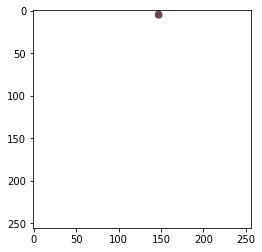

In [143]:
plt.imshow(X_train[2,:,:,:])
print((9+0.21875)*norm_const,(0+0.34375)*norm_const,0.03515625*I_S,0.03515625*I_S)
cx2=int((9+0.21875)*norm_const)
cy2=int((0+0.34375)*norm_const)
h2=int(0.03515625*I_S)
w2=int(0.03515625*I_S)
z=X_train[2,:,:,:]*255
imageWithPredBB=cv2.rectangle(z,(cx2-w2//2,cy2-h2//2),(cx2+w2//2,cy2+h2//2),(255,0,0),1)

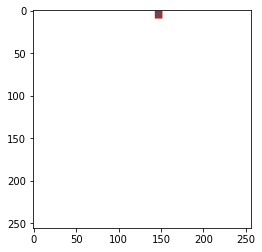

In [145]:
plt.imshow(imageWithPredBB/255)

# PLOT PERFORMANCE

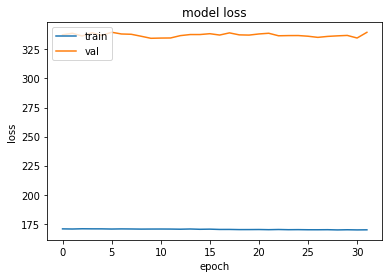

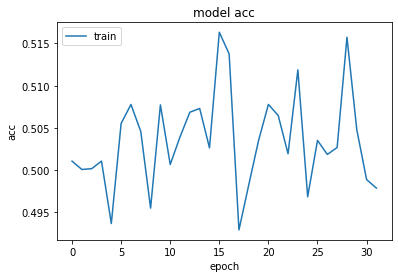

In [266]:
# PLOTTING TRAINING SET PARAMS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['mean_iou_metric'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

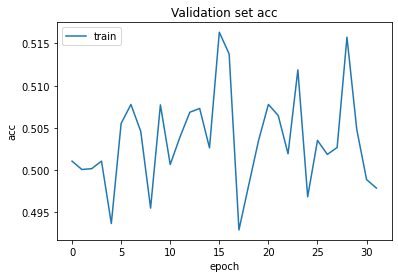

In [235]:
# VALIDATION SET CURVES
plt.plot(history.history['mean_iou_metric'])
plt.title('Validation set acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# EVALUATE ON TEST SET

In [236]:
y_pred=model.predict(X_train[0:1,:,:,:])

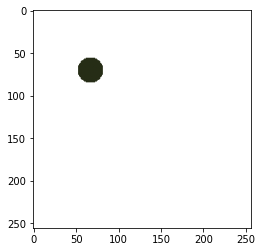

In [255]:
# for one shape, fixed size shape
#!python generateShapesAndBBoxes.py -n 5 --width 256 --height 256 --max-shapes 1 --min-shapes 1 --max-dimension 30 --min-dimension 30 --shape circle -o None
path='/content/None'
test_data=np.zeros((5,256,256,3))
test_data[0]=cv2.imread(path+'/0.png')
test_data[1]=cv2.imread(path+'/1.png')
test_data[2]=cv2.imread(path+'/2.png')
test_data[3]=cv2.imread(path+'/3.png')
test_data[4]=cv2.imread(path+'/4.png')
plt.imshow(test_data[0]/255)
test_data=test_data/255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


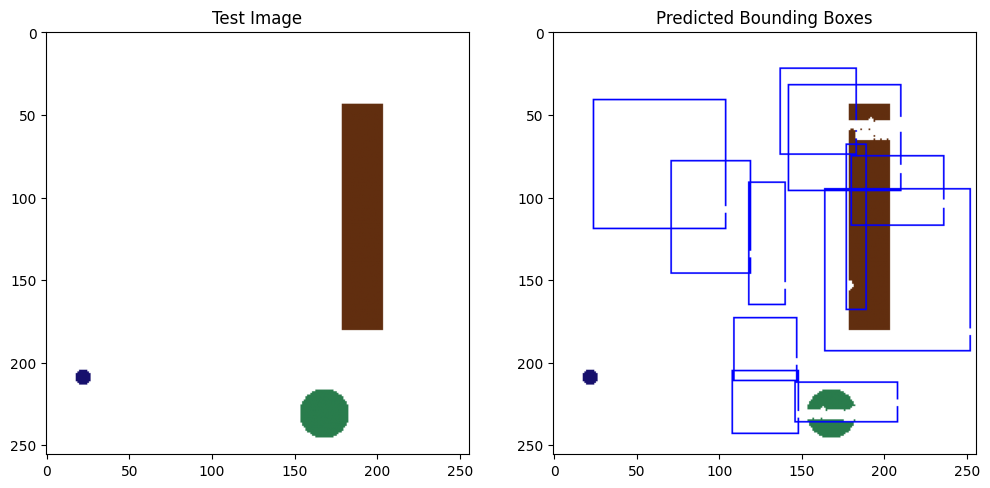

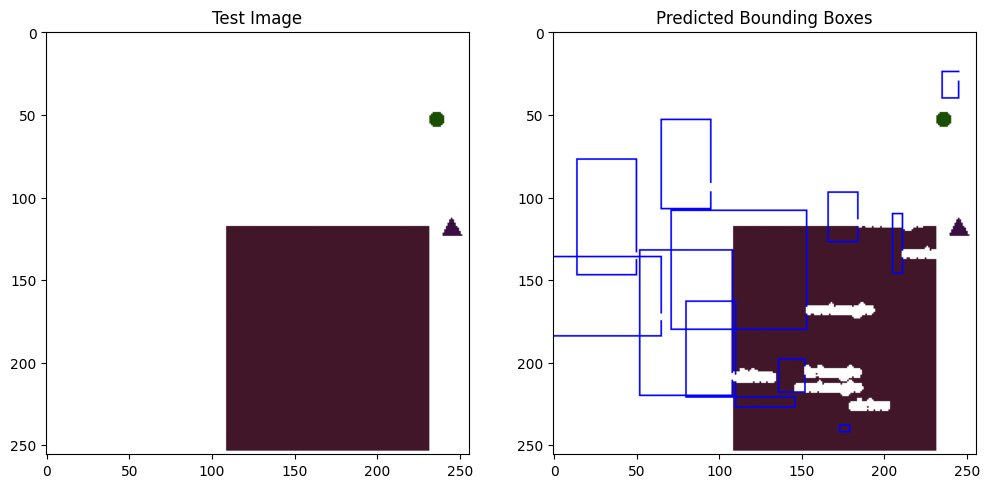

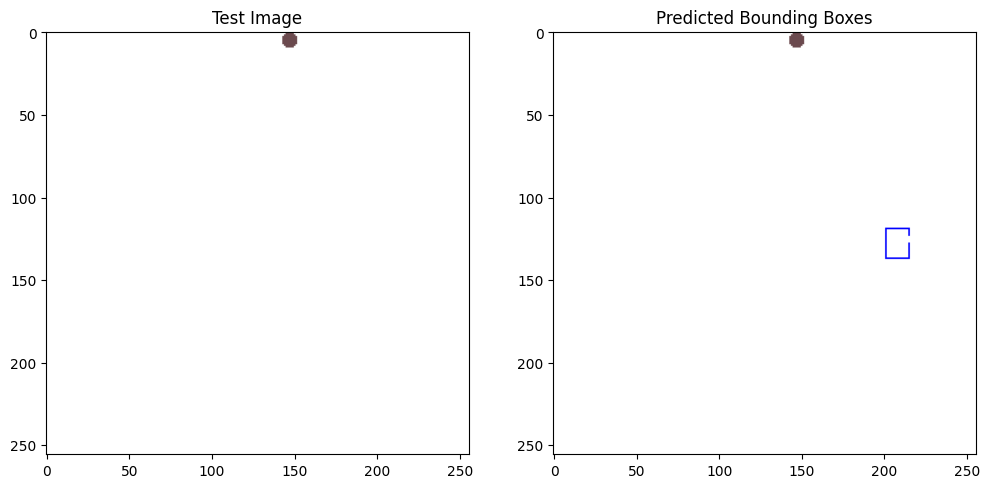

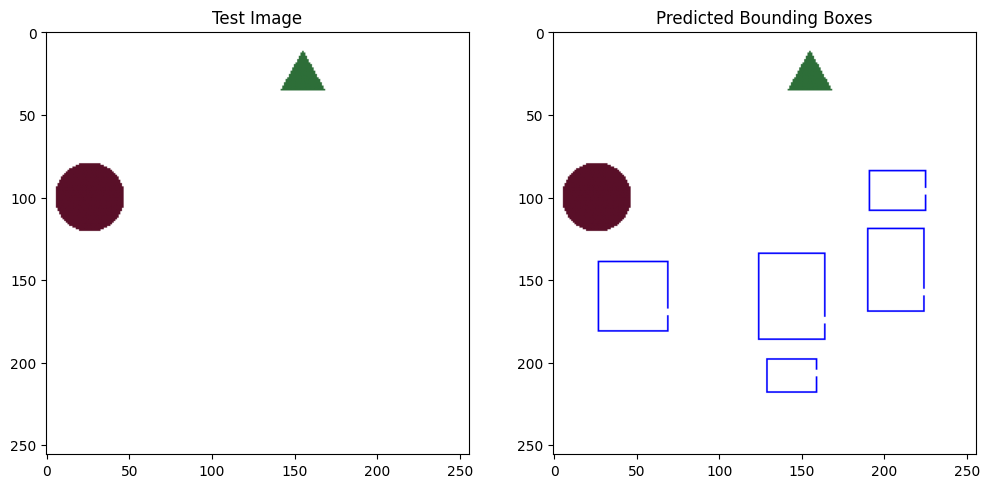

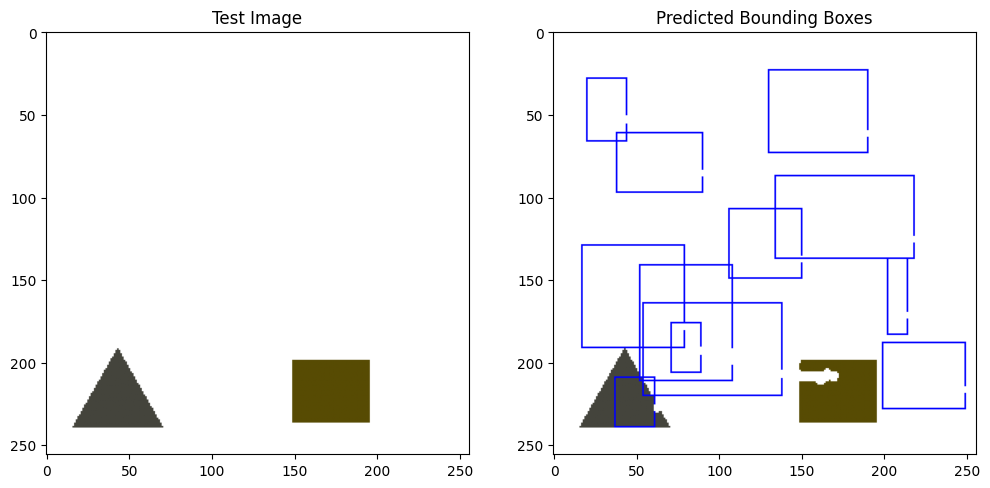

In [265]:
y_pred=model.predict(X_train[0:5,:,:,:])
for i in range(0,5):
  image=X_train[i,:,:,:]
  imageWithBB=image.copy()
  for j in range(0,S):
    for k in range(0,S):
      if y_pred[i,j,k,0]>0.01:
        cx=int(norm_const*(y_pred[i,j,k,1]+j))
        cy=int(norm_const*(y_pred[i,j,k,2]+k))
        h=int(I_S*y_pred[i,j,k,3])
        w=int(I_S*y_pred[i,j,k,4])
        imageWithBB=cv2.rectangle(imageWithBB,(cx-w//2,cy-h//2),(cx+w//2,cy+h//2),(0,0,255),1)
        cls=np.argmax(y_pred[i,j,k,5:8])
        if cls==0:
          cls='cirlce'
        elif cls==1:
          cls='triangle'
        else:
          cls='rectangle'
        imageWithBB=cv2.putText(imageWithBB,cls,(cx-w//2,cy-h//2-10),cv2.FONT_HERSHEY_COMPLEX,0.25, (3,43,123), 2)
  plt.figure(figsize=(12,8), dpi= 100)
  plt.subplot(121)
  plt.imshow(image)
  plt.title('Test Image')
  plt.subplot(122)
  plt.imshow(imageWithBB)
  plt.title('Predicted Bounding Boxes')

Text(0.5, 1.0, 'Image With Predicted Box(es)')

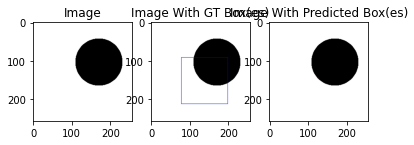

In [48]:
cx,cy,h,w=(Y_test[0,l1,l2,1]),(Y_test[0,l1,l2,2]),(Y_test[0,l1,l2,3]),(Y_test[0,l1,l2,4])
cx,cy,h,w=int((8+cx)*norm_const),int((9+cy)*norm_const),int(h*I_S),int(w*I_S)
image=X_test[0,:,:,:].astype(np.uint8)
image=image*255
imageWithBB=image.copy()
imageWithBB=cv2.rectangle(imageWithBB,(cx-w//2,cy-h//2),(cx+w//2,cy+h//2),(0,0,255),1)

#cx,cy,h,w=(y_pred[0,10,6,6]),(y_pred[0,10,6,7]),(y_pred[0,10,6,8]),(y_pred[0,10,6,9])
#cx,cy,h,w=int((8+cx)*norm_const),int((9+cy)*norm_const),int(h*I_S),int(w*I_S)
cx2,cy2,h2,w2=(y_pred[0,l1,l2,1]),(y_pred[0,l1,l2,2]),(y_pred[0,l1,l2,3]),(y_pred[0,l1,l2,4])
cx2,cy2,h2,w2=int((8+cx2)*norm_const),int((9+cy2)*norm_const),int(h2*I_S),int(w2*I_S)
imageWithPredBB=image.copy()
#imageWithPredBB=cv2.rectangle(imageWithPredBB,(cx-w//2,cy-h//2),(cx+w//2,cy+h//2),(255,0,0),1)
imageWithPredBB=cv2.rectangle(imageWithPredBB,(cx2-w2//2,cy2-h2//2),(cx2+w2//2,cy2+h2//2),(255,0,0),1)

plt.figure(1)
plt.subplot(131)
plt.imshow(image)
plt.title('Image')
plt.subplot(132)
plt.imshow(imageWithBB)
plt.title('Image With GT Box(es)')
plt.subplot(133)
plt.imshow(imageWithPredBB)
plt.title('Image With Predicted Box(es)')